# Shortest path algorithm

## [Michel Bierlaire](https://people.epfl.ch/michel.bierlaire), EPFL.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Network representation

We first define a class representing a network. It provides the successors of each node as requested by the algorithm. It also allows to draw the network, using the networkx package. 

In [2]:
class network:
    """
    Network representation
    """
    def __init__(self, nodes, arcs, coordinates = None):
        """Constructor
        
        :param nodes: list with the names of the m nodes
        :type nodes: list(str)
        
        :param arcs: a list of tuples (n1, n2, c) where 
                       - n1 is the name of the upstream node
                       - n2 is the name of the downstream node
                       - c is the cost of the arc.
        :type arcs: list(str, str, float)  
        
        :param coordinates: coordinates of the nodes for graphical representation
        :type nodes: list(float, float)
        
        """
        self.nodes = nodes
        self.arcs = arcs
        self.arcCosts = {}
        self.coordinates = coordinates
        
        self.m = len(nodes)
        self.n = len(arcs)
        
        self.successors = [list() for i in range(self.m)] 
        
        self.negativeCosts = False
        self.minCost = None
        
        for n1, n2, c in arcs:
            self.arcCosts[(n1, n2)] = c
            i1 = self.nodeIndex(n1)
            i2 = self.nodeIndex(n2)
            self.successors[i1].append((i2, c))
            if self.minCost is None:
                self.minCost = c
            elif c < self.minCost:
                self.minCost = c
            if c < 0:
                self.negativeCosts = True
                
    def nodeIndex(self, node):
        """
        The nodes are numbered from 0 to m - 1. The index is this
        internal number of the node. 
        """
        return self.nodes.index(node)

    def draw(self):
        """
        A simple drawing of the graph based on the networkx package.
        """
        g = nx.DiGraph()
        for n, c in zip(self.nodes, self.coordinates):
            g.add_node(n, pos=c)
        edge_labels = {}
        for n1, n2, c in self.arcs:
            g.add_edge(n1, n2, cost = c)
            edge_labels[(n1, n2)] = f'{c}'
        pos = nx.get_node_attributes(g, 'pos')
        nx.draw(g, pos, with_labels = True, font_weight = 'bold') 
        nx.draw_networkx_edge_labels(g, pos, edge_labels = edge_labels)
        g.clear()

# Shortest path algorithm

We now implement the shortest path algorithm. In this implementation, we keep in memory the previous node in the path, in order to easily reconstruct the shortest path tree.

This is Algorithm 23.1 in <a href="http://optimizationprinciplesalgorithms.com/">Bierlaire (2015) Optimization: principles and algorithms, EPFL Press.</a>

In [3]:
def shortestPath(network, startingNode):
    """
    :param network: the network.
    :type network: class network
    
    :param startingNode: name of the starting node.
    :type startingNode: str
    """
    
    def generateOutput():
        """
        Function preparing the output.
        """
        return {network.nodes[i]: (labels[i], network.nodes[pred[i]]) if pred[i] is not None else (labels[i], None) for i in range(m)}
    
    m = network.m
    n = network.n
    
    # We check if there are negative costs and, if so, we calculate the lower bound.
    if network.negativeCosts:
        lowerbound = (m - 1) * network.minCost
    
    # Initialization of the labels.
    labels = [np.inf for i in range(m)]
    i0 = network.nodeIndex(startingNode)
    labels[i0] = 0

    # Initialization of the predecessors
    pred = [None for i in range(m)]

    # Initialization of the set.
    S = set([i0])

    while S:
        # Choose a random node in the set and remove it
        i = S.pop()
        # Process all the successors.
        for j, c in network.successors[i]:
            if labels[j] > labels[i] + c:
                labels[j] = labels[i] + c
                if labels[j] < 0 and labels[j] < lowerbound:
                    print(f'The label of node {network.nodes[j]} is {labels[j]}, that is below the lower bound {lowerbound}. It is an unbounded problem.')
                    return generateOutput()
                S.add(j)
                pred[j] = i
    return generateOutput()

# Network 1

Preparing the network.

In [4]:
nodes = [f'{i}' for i in range(1, 10)]
coordinates = [(0, 0), 
               (2, 1.5), 
               (2, -1.5), 
               (4, 1.5), 
               (4, -1.5), 
               (6, 0), 
               (8, 1.5), 
               (10, 0), 
               (8, -1.5)]
arcs = [('1', '2', 8),
        ('1', '3', 14),
        ('2','3', 4),
        ('2','4', 9),
        ('2','5', 7),
        ('3', '5', 11),
        ('4', '5', 12),
        ('4', '6', 17),
        ('5', '6', 3),
        ('5', '9', 8),
        ('6', '7', 5),
        ('6', '8', 9),
        ('7', '8', 3),
        ('9', '8', 9)]

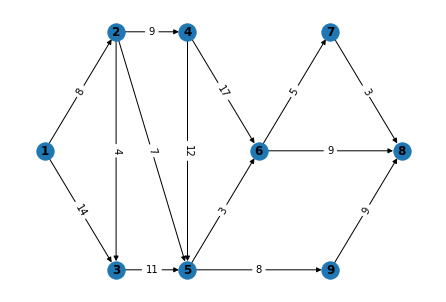

In [5]:
theNetwork = network(nodes, arcs, coordinates)
theNetwork.draw()

Calculating the shortest paths from node '1'.

In [6]:
labels = shortestPath(theNetwork, '1')

In [7]:
def printLabels(labels):
    for k, v in labels.items():
        print(f'Label of node {k}: {v[0]}. Predecessor in the shortest path: {v[1]}')   

In [8]:
printLabels(labels)

Label of node 1: 0. Predecessor in the shortest path: None
Label of node 2: 8. Predecessor in the shortest path: 1
Label of node 3: 12. Predecessor in the shortest path: 2
Label of node 4: 17. Predecessor in the shortest path: 2
Label of node 5: 15. Predecessor in the shortest path: 2
Label of node 6: 18. Predecessor in the shortest path: 5
Label of node 7: 23. Predecessor in the shortest path: 6
Label of node 8: 26. Predecessor in the shortest path: 7
Label of node 9: 23. Predecessor in the shortest path: 5


Displaying the shortest path tree.

In [9]:
shortestPathArcs = [(v[1], k, theNetwork.arcCosts[(v[1], k)]) for k, v in labels.items() if v[1] is not None]
shortestPathArcs

[('1', '2', 8),
 ('2', '3', 4),
 ('2', '4', 9),
 ('2', '5', 7),
 ('5', '6', 3),
 ('6', '7', 5),
 ('7', '8', 3),
 ('5', '9', 8)]

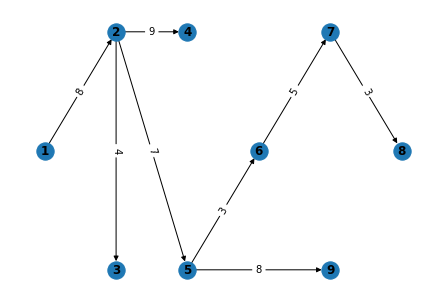

In [10]:
theShortestPathTree = network(nodes, shortestPathArcs, coordinates)
theShortestPathTree.draw()

 # Network 2

Preparing the network.

In [11]:
nodes = [f'{i}' for i in range(1, 7)]
coordinates = [(0, 0), 
               (2, 1.5), 
               (2, -1.5), 
               (4, 1.5), 
               (4, -1.5), 
               (6, 0)]
arcs = [
    ('1', '2', -1),
    ('1', '3', 3),
    ('2', '4', 7),
    ('2', '5', 5),
    ('3', '2', -9), 
    ('4', '5', 4),
    ('4', '6', 3),
    ('5', '6', -2),
    ('5', '3', -7)
]

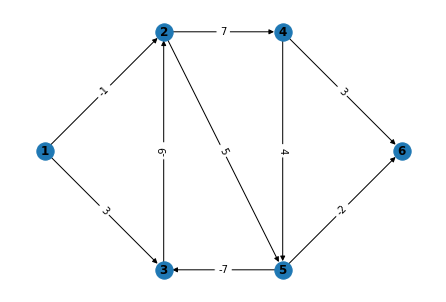

In [12]:
theNetwork = network(nodes, arcs, coordinates)
theNetwork.draw()

Calculating the shortest paths.

In [13]:
labels = shortestPath(theNetwork, '1')

The label of node 2 is -50, that is below the lower bound -45. It is an unbounded problem.


In [14]:
printLabels(labels)

Label of node 1: 0. Predecessor in the shortest path: None
Label of node 2: -50. Predecessor in the shortest path: 3
Label of node 3: -41. Predecessor in the shortest path: 5
Label of node 4: -38. Predecessor in the shortest path: 2
Label of node 5: -40. Predecessor in the shortest path: 2
Label of node 6: -36. Predecessor in the shortest path: 5
